# Geospatial analysis and representation for data science - Fattorel Marta

# AirBnB analysis

## Load necessary libraries

In [1]:
import pandas as pd
import geopandas as gpd
import folium
from branca.element import Figure
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
import osmnx as ox
from shapely.ops import transform
import pyproj
from shapely.geometry import Point, LineString, Polygon
import pyrosm
import matplotlib.pyplot as plt
import contextily as cx

##  1. Choose one of the cities available from the InsideAirbnb

Chosen city: Antwerp, in Belgium

http://insideairbnb.com/get-the-data.html

## 2. Retrieve data on neighborhoods

City data portal: https://portaal-stadantwerpen.opendata.arcgis.com/

Neighbourhoods data: https://hub.arcgis.com/datasets/aae52c04520e4f08bb187c4e68d163d1_97

In [2]:
antwerp_neigh = gpd.read_file("https://opendata.arcgis.com/datasets/aae52c04520e4f08bb187c4e68d163d1_97.geojson")

In [3]:
antwerp_neigh.head()

,OBJECTID,wijknaam,wijkcode,shape_Length,shape_Area,geometry
0,29233,Antwerpen - Amandus & Atheneum,ANT01,4669.439810,9.611707e+05,"POLYGON ((4.42424 51.22986, 4.42392 51.22985, ..."
1,29234,Antwerpen - Brederode,ANT02,3828.144204,7.777705e+05,"POLYGON ((4.39485 51.19827, 4.39475 51.19868, ..."
2,29235,Antwerpen - Centraal station,ANT03,3718.441243,7.252083e+05,"POLYGON ((4.42867 51.21682, 4.42878 51.21692, ..."
3,29236,Antwerpen - Dam,ANT04,5435.515920,1.173116e+06,"POLYGON ((4.42534 51.24075, 4.42530 51.24127, ..."
4,29237,Antwerpen - Eilandje,ANT05,6586.738534,1.992213e+06,"POLYGON ((4.40800 51.24192, 4.40789 51.24195, ..."


In [4]:
# Rename columns from dutch to english
antwerp_neigh.rename(columns={'OBJECTID':'ID', 'wijknaam': 'neigh_name', 'wijkcode': 'neigh_code'}, inplace=True)

<AxesSubplot:>

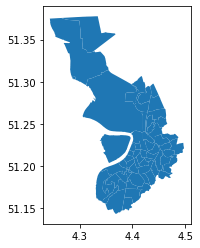

In [5]:
# Plot neighbourhoods
antwerp_neigh.plot()

It could be useful to have also the geometry of the entire city of Antwerp.

In [6]:
# Create the polygon of the city of Antwerp by aggregating all its neighbourhoods

antwerp_neigh['city'] = 'Antwerp'
antwerp = antwerp_neigh[['city', 'geometry']].dissolve(by='city')
antwerp

,geometry
city,
Antwerp,"MULTIPOLYGON (((4.40131 51.15625, 4.40125 51.1..."


<AxesSubplot:>

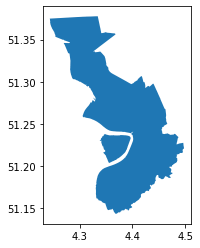

In [7]:
antwerp.plot()

## 3. View statistical information on neighborhoods

Since in the city data portal I only found a dataset with the population density, I decided to retrieve additional data from https://stadincijfers.antwerpen.be/databank.

In [8]:
# Load the excel file

population_data = pd.read_excel("Basisstatistieken 2020 - Wijken.xlsx", engine='openpyxl')

In [9]:
# Rename columns from dutch to english

population_data.rename(columns={"Unnamed: 0": "neigh_names", "Totaal aantal inwoners [aantal]": "tot_inhabitants",
                           "Percentage mannen [%]": "%_men", "Percentage vrouwen [%]": "%_women", 
                           "Bevolkingsdichtheid [pers/km²]": "population_density", "Gemiddelde leeftijd [jaar]": "average_age"}, inplace=True)

It is possible to notice that the names of the neighbourhoods are not exactly the same as the ones in the dataframe "antwerp_neigh" with all the geometries. Therefore, I created a function in order to parse them. 

In [10]:
def neigh_parser(list1, list2):
    d = {}
    for x in list2:
        for y in list1:
            x1 = x.lower().replace("-", " - ").replace("(", "").replace(")", "").replace("  ", " ").replace("-", "").replace("&", "").replace("  ", " ")
            y1 = y.lower().replace("-", " - ").replace("(", "").replace(")", "").replace("  ", " ").replace("-", "").replace("&", "").replace("  ", " ")
            if x == "Zuid":
                d[x] = "Antwerpen - Zuid"
            elif x == "Polder":
                d[x] = "Bezali - Polder"
            elif x == "Donk":
                d[x] = "Ekeren - Donk"
            elif x1 in y1:
                d[x] = y
            elif len(x1.split()) == 2:
                if x1.split()[0] == y1.split()[1] and x1.split()[1] == y1.split()[0]:
                    d[x] = y
    d["Kruininge - Bremweide"] = "Deurne - Kuininge & Bremweide"
    
    return d
    

In [11]:
# As arguments: sorted lists of the neigh names as defined in the "antwerp_neigh" dataset and in the "population_data" dataset
data = neigh_parser(sorted(list(antwerp_neigh.neigh_name.unique())), sorted(list(population_data.neigh_names.unique())))
# Convert dictionary into pandas dataframe
data = pd.DataFrame(data.items(), columns=['neigh_names', 'neigh_name'])
data.head()

,neigh_names,neigh_name
0,Amandus - Atheneum,Antwerpen - Amandus & Atheneum
1,Borgerhout - Extra Muros,Borgerhout - Extra muros
2,Borgerhout Intra Muros Noord,Borgerhout - Intra muros (noord)
3,Borgerhout Intra Muros Zuid,Borgerhout - Intra muros (zuid)
4,Brederode,Antwerpen - Brederode


In [12]:
# Substitute old neigh names with the parsed ones

population_neigh = pd.merge(population_data, data, on = "neigh_names")
population_neigh.drop("neigh_names", axis=1, inplace=True)

In [13]:
# Add neigh geometries

population_neigh_geom = pd.merge(antwerp_neigh, population_neigh, on = "neigh_name")
population_neigh_geom.head(3)

,ID,neigh_name,neigh_code,shape_Length,shape_Area,geometry,city,tot_inhabitants,%_men,%_women,population_density,average_age
0,29233,Antwerpen - Amandus & Atheneum,ANT01,4669.439810,961170.718381,"POLYGON ((4.42424 51.22986, 4.42392 51.22985, ...",Antwerp,19722.0,0.552,0.448,20519.0,35.9
1,29234,Antwerpen - Brederode,ANT02,3828.144204,777770.502587,"POLYGON ((4.39485 51.19827, 4.39475 51.19868, ...",Antwerp,11613.0,0.525,0.475,14931.0,37.8
2,29235,Antwerpen - Centraal station,ANT03,3718.441243,725208.300120,"POLYGON ((4.42867 51.21682, 4.42878 51.21692, ...",Antwerp,7632.0,0.541,0.459,10524.0,32.4


### Gender composition of the population

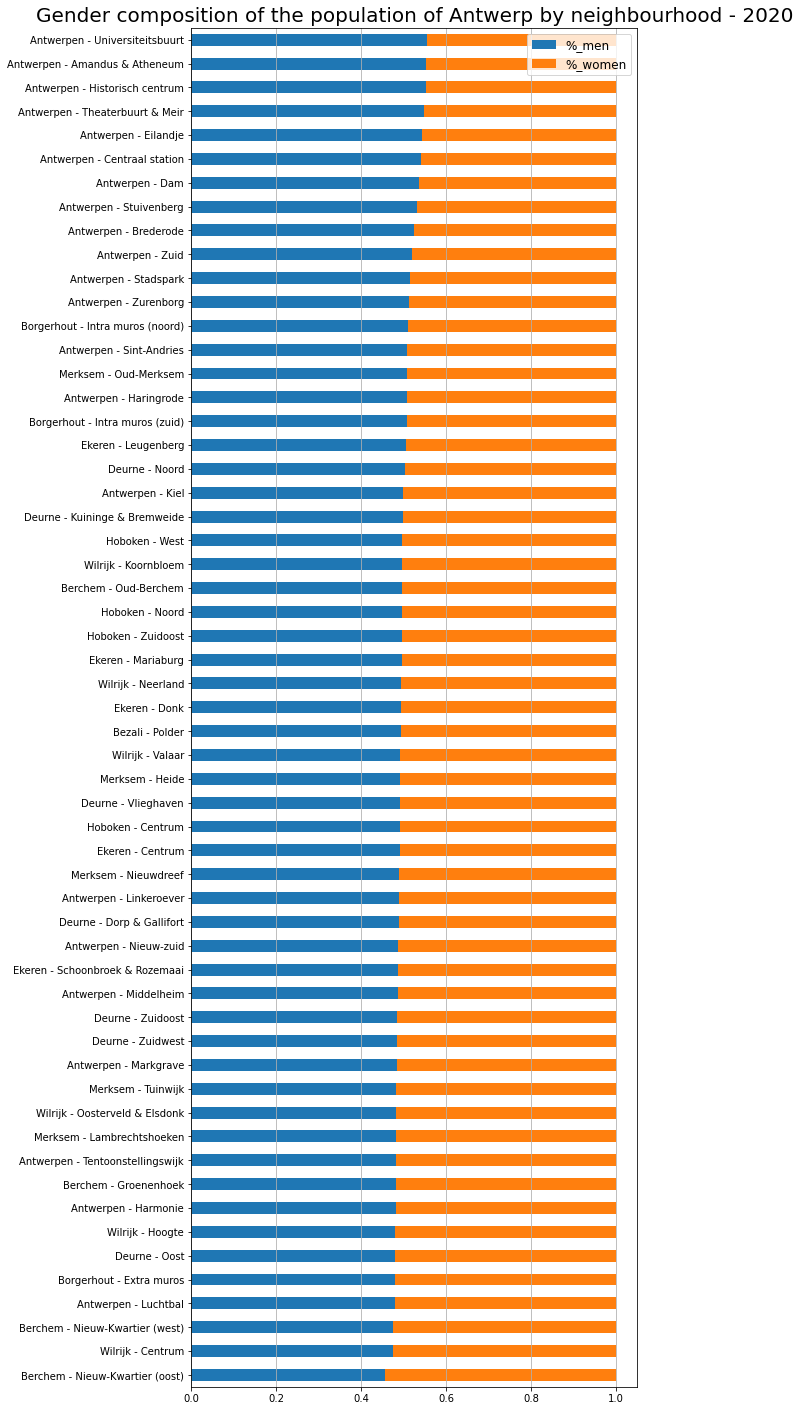

In [14]:
# Prepare dataframe
pop_gender = population_neigh_geom[["neigh_name", "%_men", "%_women"]]
pop_gender = pop_gender.set_index("neigh_name").dropna().sort_values(by='%_men', ascending=True)

# Plot data
viz = pop_gender.plot(kind='barh', stacked= True, figsize=(8, 25)).grid(axis='x')
plt.tick_params(axis='both', labelsize=10)
plt.legend(fontsize=12)
plt.ylabel("")
plt.title("Gender composition of the population of Antwerp by neighbourhood - 2020", fontdict = {'fontsize' : 20})

plt.show()

In [15]:
print("There are", pop_gender[pop_gender["%_men"] < pop_gender["%_women"]].shape[0], "neighbourhoods with more women than men")
print("There are", pop_gender[pop_gender["%_men"] > pop_gender["%_women"]].shape[0], "neighbourhoods with more men than women")

There are 38 neighbourhoods with more women than men
There are 19 neighbourhoods with more men than women


However, by looking at the barplot and at the dataframe, the results appear to be quite balanced insofar for each neighbourhood the difference between the two categories are not so big.

Note: some neighbourhoods are not present since there are some missing data.

### Average age by neighbourhood

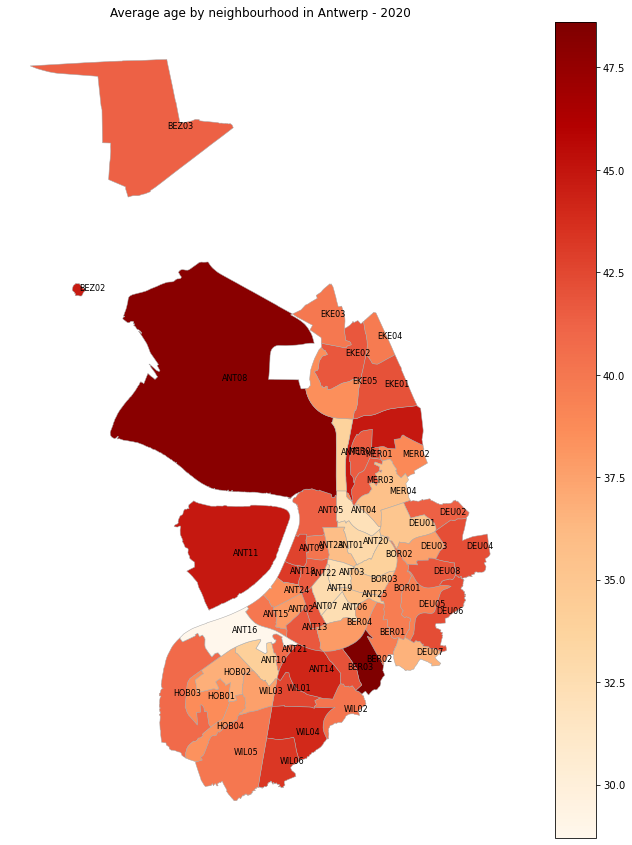

In [16]:
# Prepare dataframe
pop_age = population_neigh_geom.dropna(subset=["average_age"])

# Create Clorophlet map
ax = pop_age.plot(column='average_age',
                  cmap="OrRd", edgecolor = "darkgrey", 
                  linewidth = 0.5, legend=True, figsize = (15, 15))
ax.set_axis_off()
ax.set_title('Average age by neighbourhood in Antwerp - 2020')

# Add neighbourhood labels (code instead of name since it's shorter)
for multi, name in zip(pop_age.geometry, pop_age.neigh_code):
    plt.text(multi.representative_point().x, multi.representative_point().y, name, fontsize=8, color="black")

plt.show()

In [17]:
# Top 3 younger neighbourhoods

pop_age.sort_values(by='average_age', ascending=True).head(3)

,ID,neigh_name,neigh_code,shape_Length,shape_Area,geometry,city,tot_inhabitants,%_men,%_women,population_density,average_age
38,29271,Antwerpen - Petroleum-zuid,ANT16,12187.617749,2.877290e+06,"POLYGON ((4.39140 51.19642, 4.39082 51.19663, ...",Antwerp,15.0,NaN,NaN,NaN,28.7
3,29236,Antwerpen - Dam,ANT04,5435.515920,1.173116e+06,"POLYGON ((4.42534 51.24075, 4.42530 51.24127, ...",Antwerp,5205.0,0.535,0.465,4437.0,32.1
2,29235,Antwerpen - Centraal station,ANT03,3718.441243,7.252083e+05,"POLYGON ((4.42867 51.21682, 4.42878 51.21692, ...",Antwerp,7632.0,0.541,0.459,10524.0,32.4


In [18]:
# Top 3 older neighbourhoods

pop_age.sort_values(by='average_age', ascending=False).head(3)

,ID,neigh_name,neigh_code,shape_Length,shape_Area,geometry,city,tot_inhabitants,%_men,%_women,population_density,average_age
54,29287,Berchem - Nieuw-Kwartier (oost),BER02,6638.908953,1.690744e+06,"POLYGON ((4.43498 51.19757, 4.43498 51.19756, ...",Antwerp,10230.0,0.455,0.545,6051.0,48.6
58,29291,Antwerpen - Haven,ANT08,34648.479393,4.244341e+07,"POLYGON ((4.39797 51.29720, 4.39788 51.29724, ...",Antwerp,52.0,NaN,NaN,NaN,48.1
56,29289,Merksem - Tuinwijk,MER05,13018.053041,2.922260e+06,"POLYGON ((4.46275 51.26737, 4.46114 51.26806, ...",Antwerp,4820.0,0.483,0.517,1649.0,44.8


In [19]:
print("The average age of the entire city is", round((pop_age.average_age.sum())/pop_age.shape[0], 1))

The average age of the entire city is 39.4


### Population density

For this analysis I am going to use the data provided by the city data portal because they do not contain missing values.
https://opendata.arcgis.com/datasets/95a92f58b1ee40eb9736837b19c05579_867

Note: this data refers to 2018, not 2020 as the previous ones.

In [20]:
antwerp_population = gpd.read_file("https://opendata.arcgis.com/datasets/95a92f58b1ee40eb9736837b19c05579_867.geojson")

In [21]:
# Rename columns from dutch to english
antwerp_population.rename(columns={'OBJECTID':'ID', 'WIJKNAAM': 'neigh_name', 'WIJKCODE': 'neigh_code',
                                   'DATUM': 'timestamp', 'BEVOLKINGSDICHTHEID': 'population_density'}, inplace=True)

In [22]:
# Centroid of the city of Antwerp
centery = antwerp.iloc[0].geometry.centroid.y
centerx = antwerp.iloc[0].geometry.centroid.x

# Create basemap
fig1 = Figure(width = 800, height = 800)
m1 = folium.Map(location = [centery,centerx], tiles = 'cartodbpositron', zoom_start = 11)

folium.GeoJson(
    antwerp_population,
    style_function=lambda feature: {
        'fillColor': 'white',
        'color': 'black',
        'weight': 0.5
    }
    ).add_to(m1)

fig1.add_child(m1)

# Generate choropleth map 
folium.Choropleth(
    geo_data = antwerp_population.to_json(),
    data = antwerp_population,
    columns=['neigh_name', 'population_density'],
    key_on = 'feature.properties.neigh_name',
    fill_color = 'Reds', 
    legend_name = "Population density").add_to(m1)

# Add tooltips
folium.features.GeoJson(data = antwerp_population,
                        name = 'Labels',
                        style_function=lambda x: {'color':'transparent','fillColor':'transparent','weight':0},
                        tooltip = folium.features.GeoJsonTooltip(
                                fields= ["neigh_name", "population_density"],
                                aliases = ["Neigh. name", "Population density"],
                                labels=True,
                                sticky=False
                                                                            )
                        ).add_to(m1)
# Add title
title_html = '''
            <h3 align="center" style="font-size:20px"><b>Population density by neighbourhood in Antwerp - 2018</b></h3>
             '''
m1.get_root().html.add_child(folium.Element(title_html))

m1
m1.save(outfile = 'Pop_density_neighbourhood.geojson')

Note: Haven Bezali has value -1, which probably represents a missing value.

In [23]:
# Top 3 neighbourhood for population density

antwerp_population.sort_values(by='population_density', ascending=False).head(3)

,ID,neigh_name,neigh_code,timestamp,population_density,SHAPE_Length,SHAPE_Area,geometry
0,28955,AMANDUS - ATHENEUM,ANT01,2018-01-01T00:00:00+00:00,20713,4669.439810,9.611707e+05,"POLYGON ((4.42424 51.22986, 4.42392 51.22985, ..."
27,28982,STUIVENBERG,ANT20,2018-01-01T00:00:00+00:00,16125,5731.466172,1.178874e+06,"POLYGON ((4.42714 51.23129, 4.42654 51.23183, ..."
56,29011,BORGERHOUT INTRA MUROS ZUID,BOR03,2018-01-01T00:00:00+00:00,15761,4817.008571,9.147197e+05,"POLYGON ((4.42937 51.21707, 4.42913 51.21722, ..."


## 4. Identify which are the neighborhoods with the highest prices in AirBnB

### Load data and visualize its distribution

In [24]:
# Load airbnb data about Antwerp
antwerp_airbnb_pd = pd.read_csv("listings.csv")

In [25]:
# Plot a heatmap to visualize the geographical distribution of the airbnb

# Extract the representative point of the city of antwerp
rep_antwerp = [antwerp.geometry.representative_point()[0].y, antwerp.geometry.representative_point()[0].x]

# Create basemap
fig2 = Figure(width = 500, height = 500)
m2 = folium.Map(location = rep_antwerp, tiles ='cartodbpositron', zoom_start = 11)

# heatmap
HeatMap(antwerp_airbnb_pd[['latitude', 'longitude']]).add_to(m2)

fig2.add_child(m2)
# m2.save(outfile = 'airbnb_heatmap.html')

In [26]:
# transform into a geodataframe
antwerp_airbnb = gpd.GeoDataFrame(antwerp_airbnb_pd, crs='EPSG:4326', geometry=gpd.points_from_xy(antwerp_airbnb_pd.longitude, antwerp_airbnb_pd.latitude))
antwerp_airbnb.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,geometry
0,50904,https://www.airbnb.com/rooms/50904,20201026165813,2020-10-26,aplace/antwerp: cosy suite - fashion district,Decorated in a vintage style combined with a f...,NaN,https://a0.muscache.com/pictures/f14b0908-cbc3...,234077,https://www.airbnb.com/users/show/234077,...,10.0,10.0,NaN,f,4,2,0,0,0.01,POINT (4.39901 51.21825)
1,116134,https://www.airbnb.com/rooms/116134,20201026165813,2020-10-26,Trendy Vacation Apartment Antwerp,Enjoy your stay at our 4 person apartment in t...,"The area ""`t eilandje"" is located at the old h...",https://a0.muscache.com/pictures/23732573/0708...,586942,https://www.airbnb.com/users/show/586942,...,10.0,10.0,NaN,t,1,1,0,0,0.96,POINT (4.40593 51.23051)
2,224333,https://www.airbnb.com/rooms/224333,20201026165813,2020-10-26,Large stylish room in 1930s house + garden,"Large bedroom in classic 1930s house. Kitchen,...",The house is located in one of the most beauti...,https://a0.muscache.com/pictures/391aac86-f37e...,1167377,https://www.airbnb.com/users/show/1167377,...,10.0,10.0,NaN,f,2,0,2,0,0.02,POINT (4.45853 51.19772)


In [27]:
# Transform price form string into float and convert it from $ to euros

antwerp_airbnb["price_euros"] = round(antwerp_airbnb.price.apply(lambda x: float(x.lstrip("$").replace(",", "")) * 0.82), 2)
antwerp_airbnb.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,geometry,price_euros
0,50904,https://www.airbnb.com/rooms/50904,20201026165813,2020-10-26,aplace/antwerp: cosy suite - fashion district,Decorated in a vintage style combined with a f...,NaN,https://a0.muscache.com/pictures/f14b0908-cbc3...,234077,https://www.airbnb.com/users/show/234077,...,10.0,NaN,f,4,2,0,0,0.01,POINT (4.39901 51.21825),89.38
1,116134,https://www.airbnb.com/rooms/116134,20201026165813,2020-10-26,Trendy Vacation Apartment Antwerp,Enjoy your stay at our 4 person apartment in t...,"The area ""`t eilandje"" is located at the old h...",https://a0.muscache.com/pictures/23732573/0708...,586942,https://www.airbnb.com/users/show/586942,...,10.0,NaN,t,1,1,0,0,0.96,POINT (4.40593 51.23051),123.00
2,224333,https://www.airbnb.com/rooms/224333,20201026165813,2020-10-26,Large stylish room in 1930s house + garden,"Large bedroom in classic 1930s house. Kitchen,...",The house is located in one of the most beauti...,https://a0.muscache.com/pictures/391aac86-f37e...,1167377,https://www.airbnb.com/users/show/1167377,...,10.0,NaN,f,2,0,2,0,0.02,POINT (4.45853 51.19772),13.12


In [28]:
# With a spatial join operation, identify the neighbourhood where each airbnb is located
airbnb_and_neigh = gpd.sjoin(antwerp_neigh, 
                             antwerp_airbnb, how='inner', op='contains', lsuffix='neigh_', rsuffix='airbnb_')

In [29]:
antwerp_airbnb.shape

(1703, 76)

In [30]:
airbnb_and_neigh.shape

(1702, 83)

It appears that in the new dataframe "airbnb_and_neigh", one airbnb is not included. Probably it is not located in Antwerp.
Let's check it.

In [31]:
# create a column called "in_antwerp" and check which airbnb are within the city of Antwerp (True) and which are not (False)
antwerp_airbnb["in_antwerp"] = antwerp_airbnb.geometry.within(antwerp.geometry[0])

# Not in Antwerp
antwerp_airbnb[antwerp_airbnb.in_antwerp == False]

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,geometry,price_euros,in_antwerp
1586,44426305,https://www.airbnb.com/rooms/44426305,20201026165813,2020-10-26,Gezellige privé-kamer op de grens met Antwerpen,"Very calm neighbourhood, next to tramstop (tra...","Very calm neighbourhood, but very central loca...",https://a0.muscache.com/pictures/7b785923-78f6...,8023038,https://www.airbnb.com/users/show/8023038,...,NaN,f,1,0,1,0,NaN,POINT (4.48292 51.20279),36.9,False


In fact, if we search "Gezellige privé-kamer op de grens met Antwerpen" on the airbnb website, we can see that it is located in the city of Borsbeek, near Antwerp.

In [32]:
# Group airbnb by neighbourhood and aggregate them according to the average price. Afterwards, sort in descening order

airbnb_price = airbnb_and_neigh.groupby(["neigh_name"])["price_euros"].mean().reset_index()
airbnb_price["price_euros"] = round(airbnb_price.price_euros, 2)
airbnb_price.sort_values(by=['price_euros'], ascending = False)

,neigh_name,price_euros
28,Bezali - Polder,191.47
36,Deurne - Zuidoost,143.63
46,Hoboken - Zuidoost,139.40
5,Antwerpen - Haringrode,104.16
41,Ekeren - Mariaburg,98.40
27,Bezali - Lillo,98.40
54,Wilrijk - Oosterveld & Elsdonk,92.82
4,Antwerpen - Eilandje,91.51
13,Antwerpen - Nieuw-zuid,90.20
20,Antwerpen - Universiteitsbuurt,88.59


In [33]:
# Merge in order to have neighbourhoods and their geometry and price in a unique dataframe, to visualize data on a map

neigh_price = pd.merge(antwerp_neigh, airbnb_price, on = 'neigh_name')

In [34]:
# Centroid of the city of Antwerp
centery = antwerp.iloc[0].geometry.centroid.y
centerx = antwerp.iloc[0].geometry.centroid.x

# Create basemap
fig3 = Figure(width = 800, height = 800)
m3 = folium.Map(location = [centery,centerx], tiles = 'cartodbpositron', zoom_start = 11)

folium.GeoJson(
    antwerp_neigh,
    style_function=lambda feature: {
        'fillColor': 'white',
        'color': 'black',
        'weight': 0.5
    }
    ).add_to(m3)

fig3.add_child(m3)

# Generate choropleth map 
folium.Choropleth(
    geo_data = neigh_price.to_json(),
    data = neigh_price,
    columns=['neigh_name', 'price_euros'],
    key_on = 'feature.properties.neigh_name',
    fill_color = 'Reds', 
    legend_name = "Average price in euros").add_to(m3)

# Add tooltips
folium.features.GeoJson(data = neigh_price,
                        name = 'Labels',
                        style_function=lambda x: {'color':'transparent','fillColor':'transparent','weight':0},
                        tooltip = folium.features.GeoJsonTooltip(
                                fields= ["neigh_name", "price_euros"],
                                aliases = ["Neigh. name", "€"],
                                labels=True,
                                sticky=False
                                                                            )
                        ).add_to(m3)
# Add title
title_html = '''
            <h3 align="center" style="font-size:20px"><b>Average Airbnb price by neighbourhood in Antwerp</b></h3>
             '''
m3.get_root().html.add_child(folium.Element(title_html))

m3.save(outfile = 'airbnb_price_neigh.geojson')

The first 5 neighbourhoods for average price are: 

1. Bezali - Polder
2. Deurne - Zuidoost
3. Hoboken - Zuidoost
4. Antwerpen - Haringrode
5. Ekeren - Mariaburg

Note: the white neighbourhoods without tooltips have no Airbnb.

However, the highest prices are not registered in the most central neighbourhoods which are the ones located in the district called "Antwerpen". Instead of computing the average price, let's look at the most expensive airbnb by district.

In [35]:
airbnb_max_price = airbnb_and_neigh.groupby(["neigh_name"])["price_euros"].max().reset_index()
airbnb_max_price["price_euros"] = round(airbnb_max_price.price_euros, 2)
airbnb_max_price.sort_values(by=['price_euros'],ascending=False)

,neigh_name,price_euros
16,Antwerpen - Stadspark,2624.00
20,Antwerpen - Universiteitsbuurt,1411.22
7,Antwerpen - Historisch centrum,922.50
31,Borgerhout - Intra muros (zuid),913.48
26,Berchem - Oud-Berchem,821.64
30,Borgerhout - Intra muros (noord),820.00
36,Deurne - Zuidoost,811.80
54,Wilrijk - Oosterveld & Elsdonk,606.80
22,Antwerpen - Zurenborg,483.80
5,Antwerpen - Haringrode,451.00


Here the most central neighbourhoods of the city (Antwerpen - Stadspark, Antwerpen - Universiteitsbuurt, Antwerpen - Historisch centrum)  occupy the first three positions.

Finally, I think it is interesting to identify the total number of Airbnb per neighbourhood.

In [36]:
# Group by neighbourhood, count the number of airbnb and sort in descending order
airbnb_number = airbnb_and_neigh.groupby(["neigh_name"]).size().to_frame('N_airbnb').reset_index()

# Add geometry and sort by N_airbnb
neigh_number = pd.merge(antwerp_neigh, airbnb_number, on = 'neigh_name').sort_values(['N_airbnb'], ascending = False)
neigh_number.head()

,ID,neigh_name,neigh_code,shape_Length,shape_Area,geometry,city,N_airbnb
32,29265,Antwerpen - Historisch centrum,ANT09,3424.955628,628460.944070,"POLYGON ((4.40334 51.22758, 4.40262 51.22759, ...",Antwerp,236
26,29259,Antwerpen - Theaterbuurt & Meir,ANT22,3988.855191,763778.810946,"POLYGON ((4.41234 51.21944, 4.41207 51.21945, ...",Antwerp,150
0,29233,Antwerpen - Amandus & Atheneum,ANT01,4669.439810,961170.718381,"POLYGON ((4.42424 51.22986, 4.42392 51.22985, ...",Antwerp,123
2,29235,Antwerpen - Centraal station,ANT03,3718.441243,725208.300120,"POLYGON ((4.42867 51.21682, 4.42878 51.21692, ...",Antwerp,103
23,29256,Antwerpen - Stadspark,ANT19,4602.925147,840038.096442,"POLYGON ((4.41758 51.21105, 4.41711 51.21195, ...",Antwerp,101


Once again, the most central neighbourhoods of the city occupy the first positions in term of highest number of Airbnb.

In [37]:
# Centroid of the city of Antwerp
centery = antwerp.iloc[0].geometry.centroid.y
centerx = antwerp.iloc[0].geometry.centroid.x

# Create basemap
fig4 = Figure(width = 800, height = 800)
m4 = folium.Map(location = [centery,centerx], tiles = 'cartodbpositron', zoom_start = 11)

folium.GeoJson(
    antwerp_neigh,
    style_function=lambda feature: {
        'fillColor': 'white',
        'color': 'black',
        'weight': 0.5
    }
    ).add_to(m4)

fig4.add_child(m4)

# Generate choropleth map 
folium.Choropleth(
    geo_data = neigh_number.to_json(),
    data = neigh_number,
    columns=['neigh_name', 'N_airbnb'],
    key_on = 'feature.properties.neigh_name',
    fill_color = 'Reds', 
    legend_name = "Number of Airbnb").add_to(m4)

# Add tooltips
folium.features.GeoJson(data = neigh_number,
                        name = 'Labels',
                        style_function=lambda x: {'color':'transparent','fillColor':'transparent','weight':0},
                        tooltip = folium.features.GeoJsonTooltip(
                                fields= ["neigh_name", "N_airbnb"],
                                aliases = ["Neigh. name", "N Airbnb"],
                                labels=True,
                                sticky=False
                                                                            )
                        ).add_to(m4)
# Add title
title_html = '''
            <h3 align="center" style="font-size:20px"><b>Total number of Airbnb by neighbourhood in Antwerp</b></h3>
             '''
m4.get_root().html.add_child(folium.Element(title_html))

# m4.save(outfile = 'airbnb_neigh.html')

The first 5 neighbourhoods for average price, which were identified before, have:

1. Bezali - Polder (2 Airbnb)
2. Deurne - Zuidoost (13 Airbnb)
3. Hoboken - Zuidoost (2 Airbnb)
4. Antwerpen - Haringrode (33 Airbnb)
5. Ekeren - Mariaburg (1 Airbnb)

## 5. Identify which are the districts with the greatest number of tourist activities (Openstreetmap and city data portal)

### Create the bounding box of the city of Antwerp and save it in a GeoJSON format

In [38]:
bbox = list(antwerp.geometry.bounds.values[0])

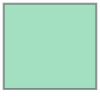

In [39]:
# Create the Polygon

minx = bbox[0]
miny = bbox[1]
maxx = bbox[2]
maxy = bbox[3]

polygon = Polygon([[minx, miny], [maxx, miny], [maxx, maxy], [minx, maxy]])
polygon

In [40]:
# Convert it into a geodataframe and save it

antwerp_bbox = {'description': ['bbox around Antwerp'], 'geometry': [polygon]}
antwerp_bbox = gpd.GeoDataFrame(antwerp_bbox, crs = "epsg:4326")
antwerp_bbox.to_file("antwerp_bbox.geojson", driver = "GeoJSON")

### Retrieve the .pbf bbox of Antwerp from export.hotosm.org

Create a new export tool called "Antwerp_bbox" and upload the "antwerp_bbox" geojson file created before. Afterwards, download the "Antwerp_bbox.osm.pbf" from the website.

https://export.hotosm.org/en/v3/exports/b0f5f5b5-935b-45d6-a890-22d521e4c9de

### Retrieve the tourist activities (artworks, galleries, information points) of Antwerp from Openstreetmap

In [41]:
# Geometry of Antwerp

antwerp_geom = antwerp.geometry.values[0]

In [42]:
osm = pyrosm.OSM("Antwerp_bbox.osm.pbf", bounding_box = antwerp_geom)

In [43]:
custom_filter = {"tourism": ["artwork", "gallery", "information"]}
other_activities = osm.get_pois(custom_filter = custom_filter)

Note: of the values belonging to the key "tourism" I selected only "artwork", "gallery", "information" because buildings such as apartments, chalet, hotels and so on are not considered "tourist activities" and because others like zoo and theme parks resulted to be 0.

Let's remove the last row of the dataframe since it is a duplicate.

In [44]:
other_activities = other_activities.iloc[0:13, :]
other_activities.head()

,changeset,tags,version,lat,id,lon,timestamp,name,information,tourism,...,osm_type,addr:city,addr:housenumber,addr:postcode,addr:street,opening_hours,operator,phone,website,museum
0,-120.0,"{""artwork_type"":""statue"",""denomination"":""roman...",3,51.170666,2109746092,4.403979,1507720022,None,None,artwork,...,node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,38.0,"{""artist_name"":""Laurence Weiner"",""artwork_type...",4,51.181446,4357801068,4.413533,1585674025,Wind en de wilgen,None,artwork,...,node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-45.0,"{""OnroerendErfgoed:criteria"":""M"",""artwork_type...",2,51.214813,4901701632,4.400321,1581497182,Beeld Moeder Zaligmakers,None,artwork,...,node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-94.0,"{""artwork_subject"":""Maria & child"",""artwork_ty...",3,51.214844,4902165380,4.400198,1581496859,None,None,artwork,...,node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-31.0,"{""artist_name"":""Joachim Lambrechts"",""artwork_t...",1,51.210682,7344143944,4.432617,1585507926,Mala Zimetbaum,None,artwork,...,node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Retrieve the museums of Antwerp from the city data portal

The city data portal offers a dataset with all the museums of the city. I decided to use this file instead of the data provided by OSM because it is richer (164 museums retrieved Vs 12 with osm). Then, I will combine this information with the activities detected before by OSM.

Museums data: https://opendata.arcgis.com/datasets/1318485a5b5f4bb0b17f4547dfef929f_293

In [45]:
antwerp_museums = gpd.read_file("https://opendata.arcgis.com/datasets/1318485a5b5f4bb0b17f4547dfef929f_293.geojson")
antwerp_museums.head(3)

,OBJECTID,GISID,locatie_adres_ID,bloso_id,type,categorie,naam,straat,huisnr,busnr,...,gemeente,link,oppervlakte,bereikbaarheid,toegankelijk,X,Y,LAT,LON,geometry
0,76911,2061,1510,0,Overdekt,Museum,Museum aan de Stroom,Hanzestedenplaats,1,None,...,Antwerpen,None,0.0000000000,None,nee,152517.9692,213162.3630,51.228391,4.404804,POINT (4.40480 51.22839)
1,76912,2066,1515,0,Overdekt,Museum,Museum Plantin-Moretus/prentenkabinet,Vrijdagmarkt,22,None,...,Antwerpen,None,0.0000000000,None,nee,152066.0323,212055.2072,51.218441,4.398328,POINT (4.39833 51.21844)
2,76913,3325,1515,0,Overdekt,Erfgoedbibliotheek,Museum Plantin-Moretus/prentenkabinet,Vrijdagmarkt,22,None,...,Antwerpen,None,0.0000000000,None,nee,152066.0323,212055.2072,51.218441,4.398328,POINT (4.39833 51.21844)


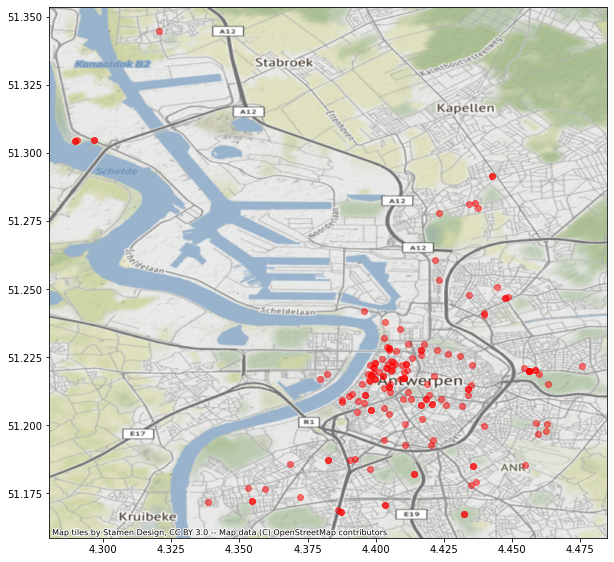

In [46]:
# Visualize the distribution of the museumns

ax = antwerp_museums.plot(alpha=0.5, color="red", figsize=(10, 10))
cx.add_basemap(ax, crs=antwerp_museums.crs.to_string(), source=cx.providers.Stamen.Terrain)

### Combine all data

In [47]:
# With a spatial join operation, identify the neighbourhood where each museum is located
museums_and_neigh = gpd.sjoin(antwerp_neigh, 
                             antwerp_museums, how='inner', op='contains', lsuffix='neigh_', rsuffix='museums_')

In [48]:
# Same process for the other activities

other_activities_and_neigh = gpd.sjoin(antwerp_neigh, 
                             other_activities, how='inner', op='contains', lsuffix='neigh_', rsuffix='other_activities_')

In [49]:
# Group museums and other activities by neighbourhood

museums_by_neigh = museums_and_neigh.groupby(["neigh_name"]).size().to_frame('N_museums').reset_index().sort_values(['N_museums', 'neigh_name'], ascending=False)
other_by_neigh = other_activities_and_neigh.groupby(["neigh_name"]).size().to_frame('N_other_activities').reset_index().sort_values(['N_other_activities', 'neigh_name'], ascending=False)

In [50]:
# Merge the two dataframes and fill NaN with 0

antwerp_tourist_activities = pd.merge(museums_by_neigh, other_by_neigh, how = 'left', on = 'neigh_name').fillna(0)
antwerp_tourist_activities["N_other_activities"] = antwerp_tourist_activities.N_other_activities.apply(lambda x: int(x))

In [51]:
# Compute the total number of tourist activities by summing the number of museums and the number of total activities
antwerp_tourist_activities["total_tourist_activities"] = antwerp_tourist_activities["N_museums"] + antwerp_tourist_activities["N_other_activities"]

# Sort by the number of total activities in descending order 
antwerp_tourist_activities = antwerp_tourist_activities.sort_values(by=['total_tourist_activities'], ascending = False)
antwerp_tourist_activities.head()

,neigh_name,N_museums,N_other_activities,total_tourist_activities
0,Antwerpen - Historisch centrum,16,0,16
1,Antwerpen - Universiteitsbuurt,12,0,12
2,Antwerpen - Eilandje,10,0,10
3,Deurne - Dorp & Gallifort,9,0,9
4,Antwerpen - Theaterbuurt & Meir,9,0,9


The top 5 neighbourhoods for tourist activities are:
1. Antwerpen - Historisch centrum
2. Antwerpen - Universiteitsbuurt
3. Antwerpen - Theaterbuurt & Meir
4. Antwerpen - Eilandje
5. Deurne - Dorp & Gallifort

The top 3 positions are occupied by the most central neighbourhoods of the city: the historic centre, the neighbourhood in which the University of Antwerp is located and the main shopping street. 

### Visualize data

In [52]:
# Add geometries in order to plot data on a map

antwerp_activities_geom = pd.merge(antwerp_neigh, antwerp_tourist_activities, how = 'left', on = 'neigh_name').fillna(0)

# Convert from float to integer numbers
antwerp_activities_geom["N_museums"] = antwerp_activities_geom.N_museums.apply(lambda x: int(x))
antwerp_activities_geom["N_other_activities"] = antwerp_activities_geom.N_other_activities.apply(lambda x: int(x))
antwerp_activities_geom["total_tourist_activities"] = antwerp_activities_geom.total_tourist_activities.apply(lambda x: int(x))

antwerp_activities_geom.head(3)

,ID,neigh_name,neigh_code,shape_Length,shape_Area,geometry,city,N_museums,N_other_activities,total_tourist_activities
0,29233,Antwerpen - Amandus & Atheneum,ANT01,4669.439810,961170.718381,"POLYGON ((4.42424 51.22986, 4.42392 51.22985, ...",Antwerp,4,0,4
1,29234,Antwerpen - Brederode,ANT02,3828.144204,777770.502587,"POLYGON ((4.39485 51.19827, 4.39475 51.19868, ...",Antwerp,4,0,4
2,29235,Antwerpen - Centraal station,ANT03,3718.441243,725208.300120,"POLYGON ((4.42867 51.21682, 4.42878 51.21692, ...",Antwerp,3,0,3


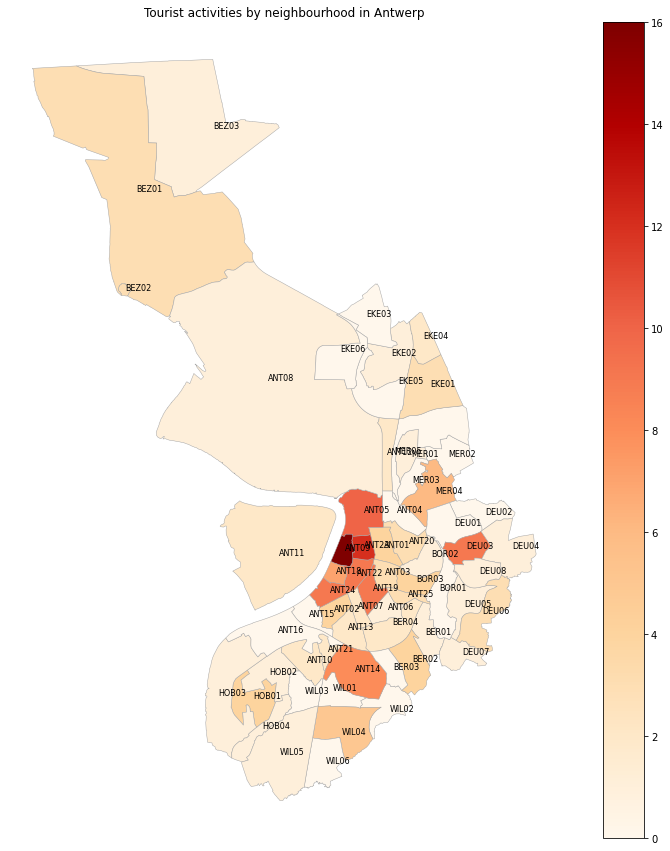

In [53]:
# Create Clorophlet map

ax = antwerp_activities_geom.plot(column='total_tourist_activities',
                                  cmap="OrRd", edgecolor = "darkgrey", 
                                  linewidth = 0.5, legend=True, figsize = (15, 15))
ax.set_axis_off()
ax.set_title('Tourist activities by neighbourhood in Antwerp')

# Add neighbourhood labels (code instead of name since it's shorter)
for multi, name in zip(antwerp_activities_geom.geometry, antwerp_activities_geom.neigh_code):
    plt.text(multi.representative_point().x, multi.representative_point().y, name, fontsize=8, color="black")

plt.show()

## 6. Find the location of 3 AirBnB hosts closest to one of the city's museums (on walking distance)

In [54]:
# Prepare dataframe

# Keep only useful columns
airbnb_and_neigh_subset = airbnb_and_neigh[["neigh_name", "neigh_code", "id", "listing_url", "name"]]

# Add geometry
airbnb_and_neigh_subset = pd.merge(airbnb_and_neigh_subset, antwerp_airbnb[["id", "geometry"]], on="id")

# To geodataframe
airbnb_and_neigh_subset = gpd.GeoDataFrame(airbnb_and_neigh_subset, crs = 'EPSG:4326', geometry = airbnb_and_neigh_subset.geometry)
airbnb_and_neigh_subset.head(3)

,neigh_name,neigh_code,id,listing_url,name,geometry
0,Antwerpen - Amandus & Atheneum,ANT01,42306207,https://www.airbnb.com/rooms/42306207,entire floor in cohousing-house,POINT (4.42969 51.21769)
1,Antwerpen - Amandus & Atheneum,ANT01,37148200,https://www.airbnb.com/rooms/37148200,Cosy studio nearby Central Station,POINT (4.42972 51.21795)
2,Antwerpen - Amandus & Atheneum,ANT01,38470295,https://www.airbnb.com/rooms/38470295,"❤️ of Antwerp, Awesome bed, Netflix Included",POINT (4.42994 51.21819)


Chosen museum: Museum aan de Stroom (MAS)

It opened in 2011 and it is the largest museum in the city. The main themes are the history, art and culture of the port city of Antwerp.

![](https://www.visitflanders.com/it/binaries/82515144-d4fb-4774-ab52-cb2b18edd6e9_tcm16-132330.jpg)

### Geocoding: retrieve the coordinates of the MAS museum

In [55]:
geolocator = Nominatim(user_agent = "geospatial course")

location = geolocator.geocode("Museum aan de Stroom, Antwerp, Belgium")
mas_museum = (location.latitude, location.longitude)
point_mas = Point(mas_museum[1], mas_museum[0])
mas_museum

(51.22893535, 4.404732087612823)

In [56]:
# Neighbourhood in which MAS museum is located

def neigh_point(point, data):
    for idx, row in data.iterrows():
        if point.within(row.geometry):
            neighbourhood = row.neigh_name
            return neighbourhood
                
neighbourhood_mas = neigh_point(point_mas, antwerp_neigh)                 
print("MAS museum belongs to the", neighbourhood_mas, "neighbourhood")

MAS museum belongs to the Antwerpen - Eilandje neighbourhood


### Street network analysis: find the shortest walking paths between MAS museum and the 3 closest Airbnb

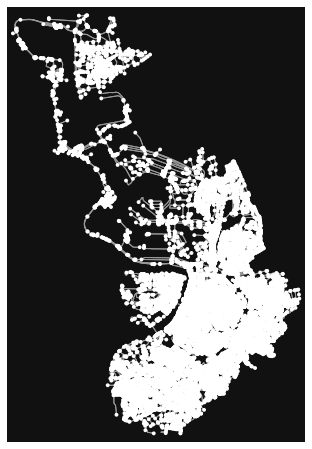

In [57]:
# Retrieve and plot all the walking streets of the city

G = ox.graph_from_place("Antwerp, Belgium", network_type='walk')
fig, ax = ox.plot_graph(G)

In [58]:
# Add speed and travel time

G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

In [59]:
# Connect the mas_museum point to the graph

node_nearest_museum = ox.get_nearest_node(G, mas_museum)

In [60]:
# Connect the airbnb points to the graph

airbnb_and_neigh_subset["points_to_graph"] = airbnb_and_neigh_subset.geometry.apply(lambda x: ox.get_nearest_node(G, (x.y, x.x)))                                                                         

In [61]:
# Find shortest paths between the museum and each Airbnb

airbnb_and_neigh_subset["paths_to_mas"] = airbnb_and_neigh_subset.points_to_graph.apply(lambda x: ox.shortest_path(G, x, node_nearest_museum, weight='travel_time'))

In [62]:
# Retrieve paths' lenth in meters

airbnb_and_neigh_subset["paths_to_mas_m"] = airbnb_and_neigh_subset.paths_to_mas.apply(lambda x: sum(ox.utils_graph.get_route_edge_attributes(G, x, 'length')))

In [63]:
# Sort in ascending order

airbnb_and_neigh_subset = airbnb_and_neigh_subset.sort_values(by='paths_to_mas_m')

In [64]:
airbnb_and_neigh_subset.head(3)

,neigh_name,neigh_code,id,listing_url,name,geometry,points_to_graph,paths_to_mas,paths_to_mas_m
298,Antwerpen - Eilandje,ANT05,8473696,https://www.airbnb.com/rooms/8473696,Home-at-Mas,POINT (4.40489 51.22846),4729290163,"[4729290163, 4729290165, 4729290162]",51.345
299,Antwerpen - Eilandje,ANT05,22703318,https://www.airbnb.com/rooms/22703318,Charming cozy 4 persons 300 m2 duplex in front...,POINT (4.40650 51.22863),4909552720,"[4909552720, 4909555025, 4729290161, 4729290162]",114.488
303,Antwerpen - Eilandje,ANT05,4592434,https://www.airbnb.com/rooms/4592434,Modern 4 pers appartement Antwerpen,POINT (4.40614 51.22946),4909552720,"[4909552720, 4909555025, 4729290161, 4729290162]",114.488


The 3 closest Airbnb to the MAS museum are:

1. https://www.airbnb.com/rooms/8473696 (51.345m)
2. https://www.airbnb.com/rooms/4592434 (114.488m)
3. https://www.airbnb.com/rooms/22703318 (114.488m)

Second and third have exactly the same distance.

Now, what about the travel time to reach these 3 Airbnb?

In [65]:
import datetime

travel_time1 = sum(ox.utils_graph.get_route_edge_attributes(G, airbnb_and_neigh_subset.paths_to_mas.iloc[0], 'travel_time'))
travel_time2 = sum(ox.utils_graph.get_route_edge_attributes(G, airbnb_and_neigh_subset.paths_to_mas.iloc[1], 'travel_time'))
travel_time3 = sum(ox.utils_graph.get_route_edge_attributes(G, airbnb_and_neigh_subset.paths_to_mas.iloc[2], 'travel_time'))

print("Travel time on foot from MAS to the first Airbnb:", str(datetime.timedelta(seconds=travel_time1)))
print("Travel time on foot from MAS to the second Airbnb:", str(datetime.timedelta(seconds=travel_time2)))
print("Travel time on foot from MAS to the third Airbnb:", str(datetime.timedelta(seconds=travel_time3)))

Travel time on foot from MAS to the first Airbnb: 0:00:08
Travel time on foot from MAS to the second Airbnb: 0:00:18
Travel time on foot from MAS to the third Airbnb: 0:00:18


### Visualize these analyses on a map

In [66]:
# Create basemap
fig5 = Figure(width = 800, height = 800)
m5 = folium.Map(location = [mas_museum[0],mas_museum[1]], tiles = 'openstreetmap', zoom_start = 16)

# Add MAS museum
folium.GeoJson(point_mas, tooltip="MAS museum").add_to(m5)

# Add Airbnb paths
ox.plot_route_folium(G, airbnb_and_neigh_subset.paths_to_mas.iloc[0], route_map=m5, tiles='OpenStreetMap', route_color="blue")
ox.plot_route_folium(G, airbnb_and_neigh_subset.paths_to_mas.iloc[1], route_map=m5, tiles='OpenStreetMap', route_opacity=0.5)
ox.plot_route_folium(G, airbnb_and_neigh_subset.paths_to_mas.iloc[2], route_map=m5, tiles='OpenStreetMap', route_color="green", route_opacity=0.5)

C:\Users\Marta\anaconda3\envs\geo_env\lib\site-packages\osmnx\folium.py:126: UserWarning: `route_color` has been deprecated and will be removed: use kwargs instead
  warn("`route_color` has been deprecated and will be removed: use kwargs instead")
C:\Users\Marta\anaconda3\envs\geo_env\lib\site-packages\osmnx\folium.py:132: UserWarning: `route_opacity` has been deprecated and will be removed: use kwargs instead
  warn("`route_opacity` has been deprecated and will be removed: use kwargs instead")


Second and third Airbnb's paths overlap.

In [67]:
# Neighbourhoods in which each Airbnb is located (use function defined before)

print("Airbnb 1 is located in", neigh_point(airbnb_and_neigh_subset.iloc[0].geometry, antwerp_neigh))
print("Airbnb 2 is located in", neigh_point(airbnb_and_neigh_subset.iloc[1].geometry, antwerp_neigh))
print("Airbnb 3 is located in", neigh_point(airbnb_and_neigh_subset.iloc[2].geometry, antwerp_neigh))

Airbnb 1 is located in Antwerpen - Eilandje
Airbnb 2 is located in Antwerpen - Eilandje
Airbnb 3 is located in Antwerpen - Eilandje


## 7. Of the three hosts, identify which one has the greatest number of services (supermarkets, pharmacies, restaurants) in an area of 300m

### Retrieve all supermarkets, pharmacies and restaurants (fast-food included) of Antwerp from Openstreetmap

Same procedure as the one done before with the tourist activities.

In [68]:
# Geometry of Antwerp

antwerp_geom = antwerp.geometry.values[0]

In [69]:
osm = pyrosm.OSM("Antwerp_bbox.osm.pbf", bounding_box = antwerp_geom)

In [70]:
custom_filter = {"amenity": ["pharmacy", "restaurant", "fast_food"], "shop": ["supermarket"]}
antwerp_services = osm.get_pois(custom_filter = custom_filter)

In [71]:
# Combine tags from "amenity" and "shop"

antwerp_services["service_type"] = antwerp_services["amenity"]
antwerp_services["service_type"] = antwerp_services["service_type"].fillna(antwerp_services["shop"])

In [72]:
antwerp_services.head(3)

,changeset,tags,version,lat,id,lon,timestamp,name,amenity,geometry,...,url,website,bar,building,building:levels,source,start_date,organic,shop,service_type
0,NaN,"{""delivery"":""no"",""outdoor_seating"":""yes"",""smok...",7,NaN,27268548,NaN,1584093404,Savanne restaurant,restaurant,"POLYGON ((4.42467 51.21651, 4.42478 51.21669, ...",...,None,None,None,yes,None,None,None,None,None,restaurant
1,NaN,"{""cuisine"":""regional""}",3,NaN,40196194,NaN,1586160497,Makro,restaurant,"POLYGON ((4.49593 51.22078, 4.49602 51.22056, ...",...,None,None,None,yes,None,None,None,None,None,restaurant
2,NaN,"{""OnroerendErfgoed:criteria"":""M"",""cuisine"":""re...",5,NaN,42648810,NaN,1502954049,Het Pomphuis,restaurant,"POLYGON ((4.40827 51.24179, 4.40819 51.24161, ...",...,None,http://www.hetpomphuis.be/,None,yes,None,None,None,None,None,restaurant


### Change crs (from WSG 84 to UTM31N) in order to extract the buffers around the three Airbnb

In [86]:
# 3 Airbnb closest to MAS

airbnb1 = airbnb_and_neigh_subset[airbnb_and_neigh_subset.listing_url == "https://www.airbnb.com/rooms/8473696"]
airbnb2 = airbnb_and_neigh_subset[airbnb_and_neigh_subset.listing_url == "https://www.airbnb.com/rooms/4592434"]
airbnb3 = airbnb_and_neigh_subset[airbnb_and_neigh_subset.listing_url == "https://www.airbnb.com/rooms/22703318"]

In [87]:
# Change crs to be able to compute the buffer in meters

wgs84 = pyproj.CRS('EPSG:4326')
utm31n = pyproj.CRS('EPSG:32631')
projection_transform = pyproj.Transformer.from_crs(wgs84, utm31n, always_xy=False).transform

airbnb1_utm31n = transform(projection_transform, Point(airbnb1.geometry.y, airbnb1.geometry.x))
airbnb2_utm31n = transform(projection_transform, Point(airbnb2.geometry.y, airbnb2.geometry.x))
airbnb3_utm31n = transform(projection_transform, Point(airbnb3.geometry.y, airbnb3.geometry.x))

In [88]:
# Convert the dataframe with the services as well

antwerp_services_utm31n = antwerp_services.to_crs('epsg:32631')

In [89]:
# Create basemap
fig6 = Figure(width = 800, height = 800)
m6 = folium.Map(location = [mas_museum[0],mas_museum[1]], tiles = 'openstreetmap', zoom_start = 11)

# Add Airbnb
folium.GeoJson(airbnb1.geometry, tooltip="Airbnb 1").add_to(m6)
folium.GeoJson(airbnb2.geometry, tooltip="Airbnb 2").add_to(m6)
folium.GeoJson(airbnb3.geometry, tooltip="Airbnb 3").add_to(m6)

# Add geometry of the city of Antwerp
folium.GeoJson(
    antwerp,
    style_function=lambda feature: {
        'fillColor': 'red',
        'color': 'black',
        'weight': 0.5
    }
    ).add_to(m6)

# Plot all the services retrieved by osm
folium.GeoJson(
    antwerp_services
    ).add_to(m6)

fig6.add_child(m6)
m6
# m6.save(outfile = 'services_airbnb.html')

Note: since within a 300 m buffer there results to be only one service, I decided to extend it to 800 m. 

In [90]:
services_around_airbnb1 = antwerp_services_utm31n[antwerp_services_utm31n.geometry.within(airbnb1_utm31n.buffer(800))]
services_around_airbnb1

,changeset,tags,version,lat,id,lon,timestamp,name,amenity,geometry,...,url,website,bar,building,building:levels,source,start_date,organic,shop,service_type
24,NaN,"{""cuisine"":""regional""}",6,NaN,116180040,NaN,1498668490,'t lastig portret,restaurant,"POLYGON ((598211.024 5675544.191, 598212.675 5...",...,None,None,None,yes,None,None,None,None,None,restaurant
50,NaN,"{""cuisine"":""international""}",2,NaN,239552389,NaN,1503071227,Windkracht 13,restaurant,"POLYGON ((597375.460 5676483.794, 597383.479 5...",...,None,None,None,yes,None,None,None,None,None,restaurant
76,NaN,"{""alt_name"":""U eat & sleep"",""tourism"":""hotel""}",4,NaN,483462288,NaN,1546453252,U,restaurant,"POLYGON ((598099.898 5676321.657, 598105.864 5...",...,None,http://www.u-eatsleep.be/,None,yes,None,None,None,None,None,restaurant
78,NaN,"{""diet:vegan"":""only"",""diet:vegetarian"":""yes"",""...",3,NaN,496711213,NaN,1566888921,Sweet Vegan,fast_food,"POLYGON ((597745.795 5675463.624, 597747.293 5...",...,None,https://www.sweetvegan.be,None,yes,None,None,None,None,None,fast_food


In [91]:
services_around_airbnb2 = antwerp_services_utm31n[antwerp_services_utm31n.geometry.within(airbnb2_utm31n.buffer(800))]
services_around_airbnb2

,changeset,tags,version,lat,id,lon,timestamp,name,amenity,geometry,...,url,website,bar,building,building:levels,source,start_date,organic,shop,service_type
24,NaN,"{""cuisine"":""regional""}",6,NaN,116180040,NaN,1498668490,'t lastig portret,restaurant,"POLYGON ((598211.024 5675544.191, 598212.675 5...",...,None,None,None,yes,None,None,None,None,None,restaurant
76,NaN,"{""alt_name"":""U eat & sleep"",""tourism"":""hotel""}",4,NaN,483462288,NaN,1546453252,U,restaurant,"POLYGON ((598099.898 5676321.657, 598105.864 5...",...,None,http://www.u-eatsleep.be/,None,yes,None,None,None,None,None,restaurant


In [92]:
services_around_airbnb3 = antwerp_services_utm31n[antwerp_services_utm31n.geometry.within(airbnb3_utm31n.buffer(800))]
services_around_airbnb3

,changeset,tags,version,lat,id,lon,timestamp,name,amenity,geometry,...,url,website,bar,building,building:levels,source,start_date,organic,shop,service_type
24,NaN,"{""cuisine"":""regional""}",6,NaN,116180040,NaN,1498668490,'t lastig portret,restaurant,"POLYGON ((598211.024 5675544.191, 598212.675 5...",...,None,None,None,yes,None,None,None,None,None,restaurant
76,NaN,"{""alt_name"":""U eat & sleep"",""tourism"":""hotel""}",4,NaN,483462288,NaN,1546453252,U,restaurant,"POLYGON ((598099.898 5676321.657, 598105.864 5...",...,None,http://www.u-eatsleep.be/,None,yes,None,None,None,None,None,restaurant


The Airbnb with the highest number of services results to be the first one. It has 3 restaurants and 1 fast food within a 800 m buffer. However, the number of retrieved services appears to be quite low (i.e. no supermarkets or pharmacies). In fact, by looking at Google Maps, it appears that osm has not retrieved all the services of the area.

## 8. Analyze and test spatial autocorrelation of price

In order to do so, I am going to use the "neigh_price" dataframe created at point 4. However, I am going to add also the neighbourhoods without Airbnb and give them a mean price of 0. I think that this information is important when analyzing the spatial autocorrelation of price. As we saw in the previous maps, the neighbourhoods without Airbnb are the less central, with less tourist activities and probably the cheapest ones in terms of general services.

In [99]:
# Add all neighbourhoods

all_neigh = pd.merge(antwerp_neigh, neigh_price[["neigh_code", "price_euros"]], how="left", on="neigh_code").fillna(0)

In [100]:
# Save in .shp

all_neigh.to_file("neigh_price.shp")

In [101]:
# Load the extension to include R code

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [102]:
%%R

library(rgdal)
library(spdep)

In [103]:
%%R

# Load .shp file
neigh_price <- readOGR("neigh_price","neigh_price")
summary(neigh_price)

OGR data source with driver: ESRI Shapefile 
Source: "", layer: "neigh_price"
with 63 features
It has 7 fields
Integer64 fields read as strings:  ID 


From cffi callback <function _consolewrite_ex at 0x000001EE1B5BD160>:
Traceback (most recent call last):
  File "C:\Users\Marta\anaconda3\envs\geo_env\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 132, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "C:\Users\Marta\anaconda3\envs\geo_env\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 133, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe0 in position 38: invalid continuation byte


Object of class SpatialPolygonsDataFrame
Coordinates:
        min       max
x  4.243408  4.497903
y 51.143323 51.377664
Is projected: FALSE 
proj4string : [+proj=longlat +datum=WGS84 +no_defs]
Data attributes:
      ID             neigh_name         neigh_code          shape_Leng   
 Length:63          Length:63          Length:63          Min.   : 1482  
 Class :character   Class :character   Class :character   1st Qu.: 4683  
 Mode  :character   Mode  :character   Mode  :character   Median : 6143  
                                                          Mean   : 7537  
                                                          3rd Qu.: 8109  
                                                          Max.   :34648  
   shape_Area           city             price_euro    
 Min.   :  133651   Length:63          Min.   :  0.00  
 1st Qu.:  907838   Class :character   1st Qu.: 43.46  
 Median : 1279334   Mode  :character   Median : 62.44  
 Mean   : 2966304                      Mean   : 

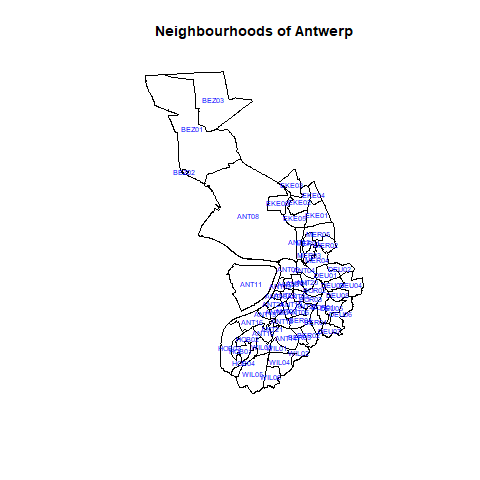

In [104]:
%%R

# Visualize the geometries of the neighbourhoods of the city.
plot(neigh_price)
text(coordinates(neigh_price), labels=neigh_price$neigh_code, cex=0.6, col="blue")
title(main = "Neighbourhoods of Antwerp")

### Build the spatial weights matrix

The first step to test any spatial correlation is to build a spatial weights matrix. It is a good practice to build different ones, according to different definitions of neighbourhood relationships amongst the spatial units.

Let's start with the **k-nearest neighbours** criterion and in particular with k=1.

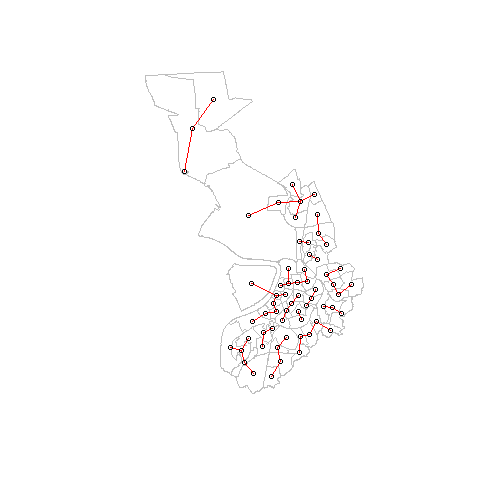

In [105]:
%%R

# Compute centroids as representative points of the neighbourhoods of Antwerp
centroids <- coordinates(neigh_price)

# knn algorithm
knn1 <- knn2nb(knearneigh(centroids, k=1, longlat = T))

# Visualize them
plot(neigh_price, border="grey")
plot(knn1, centroids, col="red", add=TRUE)

In [106]:
%%R

# Build a row standardize weights matrix 

knn1.listw <- nb2listw(knn1, style = "W")

Build the spatial weights matrix according to the **critical cut-off neighbourhood** criterion and choose different cut-off levels.

In [107]:
%%R

# Compute the min distance since we want all neighbourhoods to have at least one neighbour

min.dist <- max(unlist(nbdists(knn1, centroids, longlat=T)))
min.dist

[1] 3.56063


In [108]:
%%R

# Different cut-off levels

dnb1 <- dnearneigh(centroids, 0, 4, longlat = TRUE)
dnb2 <- dnearneigh(centroids, 0, 8, longlat = TRUE)
dnb3 <- dnearneigh(centroids, 0, 12, longlat = TRUE)

# Build row standardize matrices

dnb1.listw <- nb2listw(dnb1, style = "W")
dnb2.listw <- nb2listw(dnb2, style = "W")
dnb3.listw <- nb2listw(dnb3, style = "W")

**Free-form spatial weight matrix**: create weights as inverse functions of the distance among centroids.

In [109]:
%%R

distM <- as.matrix(dist(centroids)) # euclidean distance
W1 <- 1/(1+(distM))
diag(W1) <- 0                       # 0 values to the diagonal
W1 <- W1/rowSums(W1)                # row standardize it
listW1 <- mat2listw(W1)             # convert into a listw object for computational reasons

### Global spatial autocorrelation: Moran's I test

Visually inspect the spatial quantile distribution of the average Airbnb price.

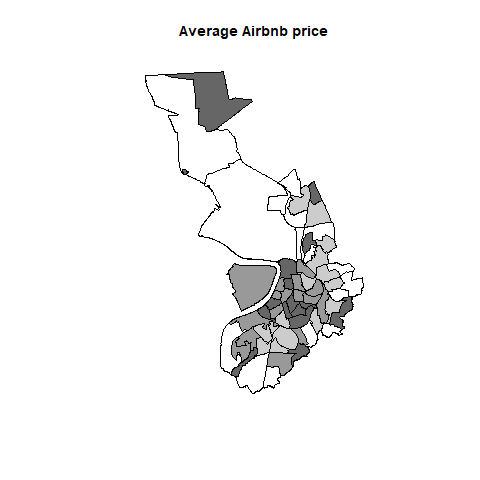

In [110]:
%%R

brks <- round(quantile(neigh_price$price_euro), digits=3)
colours <- grey((length(brks):2)/length(brks))
plot(neigh_price, col=colours[findInterval(neigh_price$price_euro, brks, all.inside=TRUE)])
title(main = "Average Airbnb price")

From the plot, there seems to be a sort of spatial dependence in the central neighbourhoods (the neighbourhoods which belong to the Antwerpen district). However, it is important to check if it is statistically significant by computing the Moran's I index.
Let's compute it for each spatial weights matrix built before, starting by assuming a **normal distribution** of our data.

In [111]:
%%R

print(moran.test(neigh_price$price_euro, knn1.listw, randomisation = FALSE)) # 1 knn
print(moran.test(neigh_price$price_euro, dnb1.listw, randomisation = FALSE)) # 4 km cut-off
print(moran.test(neigh_price$price_euro, dnb2.listw, randomisation = FALSE)) # 8 km cut-off
print(moran.test(neigh_price$price_euro, dnb3.listw, randomisation = FALSE)) # 12 km cut-off
print(moran.test(neigh_price$price_euro, listW1, randomisation = FALSE))     # free form


	Moran I test under normality

data:  neigh_price$price_euro  
weights: knn1.listw    

Moran I statistic standard deviate = -0.69761, p-value = 0.7573
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      -0.12241704       -0.01612903        0.02321336 


	Moran I test under normality

data:  neigh_price$price_euro  
weights: dnb1.listw    

Moran I statistic standard deviate = -2.4272, p-value = 0.9924
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     -0.133776555      -0.016129032       0.002349442 


	Moran I test under normality

data:  neigh_price$price_euro  
weights: dnb2.listw    

Moran I statistic standard deviate = -2.8869, p-value = 0.9981
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
    -0.0967321895     -0.0161290323      0.0007795212 


	Moran I test under normality

data:  neigh_price$price_eur

All p-values result to be really high. This tells us that we cannot reject the null hp of no spatial autocorrelation of price.


Test, according to the **randomization assumption**.

In [112]:
%%R

print(moran.test(neigh_price$price_euro, knn1.listw, randomisation = TRUE)) # 1 knn
print(moran.test(neigh_price$price_euro, dnb1.listw, randomisation = TRUE)) # 4 km cut-off
print(moran.test(neigh_price$price_euro, dnb2.listw, randomisation = TRUE)) # 8 km cut-off
print(moran.test(neigh_price$price_euro, dnb3.listw, randomisation = TRUE)) # 12 km cut-off
print(moran.test(neigh_price$price_euro, listW1, randomisation = TRUE))     # free form


	Moran I test under randomisation

data:  neigh_price$price_euro  
weights: knn1.listw    

Moran I statistic standard deviate = -0.7102, p-value = 0.7612
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      -0.12241704       -0.01612903        0.02239810 


	Moran I test under randomisation

data:  neigh_price$price_euro  
weights: dnb1.listw    

Moran I statistic standard deviate = -2.4709, p-value = 0.9933
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      -0.13377655       -0.01612903        0.00226696 


	Moran I test under randomisation

data:  neigh_price$price_euro  
weights: dnb2.listw    

Moran I statistic standard deviate = -2.9389, p-value = 0.9984
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
    -0.0967321895     -0.0161290323      0.0007521995 


	Moran I test under randomisation

data:  neigh_

These results are in line with the previous ones: really high p-values meaning that we cannot reject the null hp of no spatial autocorrelation of price.


Test according to the **bootstrap approach**.

In [113]:
%%R

print(moran.mc(neigh_price$price_euro, knn1.listw, nsim=999)) # 1 knn
print(moran.mc(neigh_price$price_euro, dnb1.listw, nsim=999)) # 4 km cut-off
print(moran.mc(neigh_price$price_euro, dnb2.listw, nsim=999)) # 8 km cut-off
print(moran.mc(neigh_price$price_euro, dnb3.listw, nsim=999)) # 12 km cut-off
print(moran.mc(neigh_price$price_euro, listW1, nsim=999))     # free form


	Monte-Carlo simulation of Moran I

data:  neigh_price$price_euro 
weights: knn1.listw  
number of simulations + 1: 1000 

statistic = -0.12242, observed rank = 245, p-value = 0.755
alternative hypothesis: greater


	Monte-Carlo simulation of Moran I

data:  neigh_price$price_euro 
weights: dnb1.listw  
number of simulations + 1: 1000 

statistic = -0.13378, observed rank = 14, p-value = 0.986
alternative hypothesis: greater


	Monte-Carlo simulation of Moran I

data:  neigh_price$price_euro 
weights: dnb2.listw  
number of simulations + 1: 1000 

statistic = -0.096732, observed rank = 8, p-value = 0.992
alternative hypothesis: greater


	Monte-Carlo simulation of Moran I

data:  neigh_price$price_euro 
weights: dnb3.listw  
number of simulations + 1: 1000 

statistic = -0.060355, observed rank = 1, p-value = 0.999
alternative hypothesis: greater


	Monte-Carlo simulation of Moran I

data:  neigh_price$price_euro 
weights: listW1  
number of simulations + 1: 1000 

statistic = -0.0164

Once again, the high p-values do not allow us to reject the null hp of no spatial autocorrelation of price.   

We can conclude stating that we have no statistical evidence of global spatial autocorrelation of price in our data.

### Local spatial autocorrelation: Moran scatterplot

Let's check if there are relevant local spatial clusters by plotting the Moran scatterplots with respect to different specifications of the spatial weights matrix.

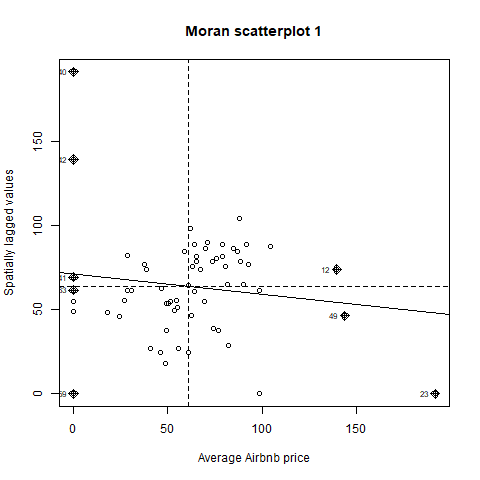

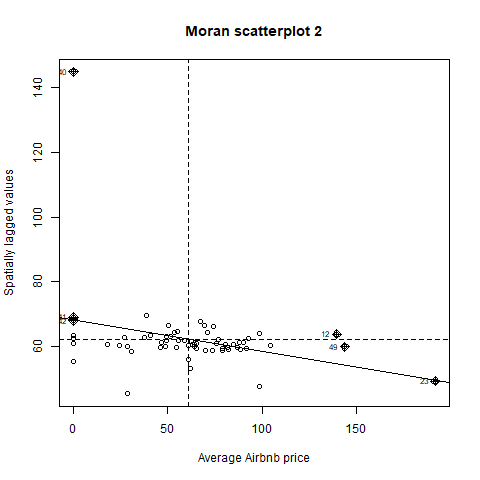

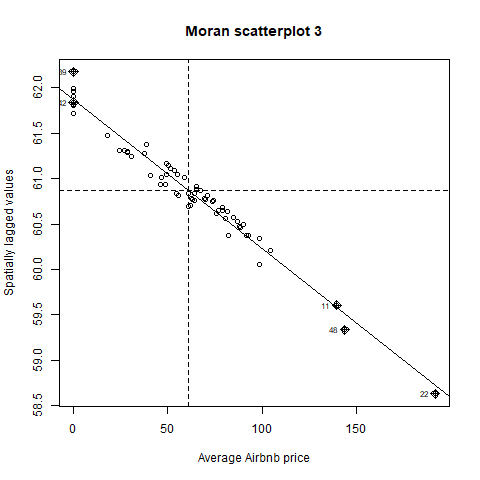

In [114]:
%%R

mplot1 <- moran.plot(neigh_price$price_euro, listw=knn1.listw, main="Moran scatterplot 1", xlab="Average Airbnb price", ylab="Spatially lagged values", return_df=F)
mplot2 <- moran.plot(neigh_price$price_euro, listw=dnb2.listw, main="Moran scatterplot 2", xlab="Average Airbnb price", ylab="Spatially lagged values", return_df=F)
mplot3 <- moran.plot(neigh_price$price_euro, listw=listW1, main="Moran scatterplot 3", xlab="Average Airbnb price", ylab="Spatially lagged values", return_df=F)

The first two plots show a really slight pattern of negative spatial autocorrelation, which becomes stronger in the third plot. This means that units close in space tend to have dissimilar price values.

In [115]:
%%R

# The summary() function isolates the most influential units with some measures of influence
summary(mplot1)
# summary(mplot2)
# summary(mplot3)

Potentially influential observations of
	 lm(formula = wx ~ x) :

   dfb.1_  dfb.x   dffit   cov.r   cook.d hat    
12 -0.13    0.20    0.22    1.12_*  0.02   0.09  
23  0.70   -0.96   -1.00_*  1.21_*  0.48   0.23_*
40  1.22_* -1.05_*  1.22_*  0.59_*  0.55   0.06  
41 -0.02    0.02   -0.02    1.10_*  0.00   0.06  
42  0.62   -0.53    0.62_*  0.92    0.18   0.06  
49  0.05   -0.08   -0.09    1.15_*  0.00   0.10_*
59 -0.65    0.56   -0.65_*  0.90    0.19   0.06  
63 -0.08    0.07   -0.08    1.10_*  0.00   0.06  


### Local spatial autocorrelation: local Moran's I index

The Moran scatterplot gives us an intuitive visual representation of local patterns of spatial autocorrelation, but we need to compute the local Moran's I index to understand if it is statistically significant.

In [116]:
%%R

# Again use different specifications of the spatial weights matrix

lmI1 <- localmoran(neigh_price$price_euro, knn1.listw)
print(head(lmI1))
lmI2 <- localmoran(neigh_price$price_euro, dnb2.listw)
print(head(lmI2))
lmI3 <- localmoran(neigh_price$price_euro, listW1)
print(head(lmI3))

             Ii        E.Ii    Var.Ii       Z.Ii Pr(z > 0)
1  0.0724045985 -0.01612903 0.9357581 0.09152221 0.4635388
2  0.0649172968 -0.01612903 0.9357581 0.08378216 0.4666148
3  0.1791897473 -0.01612903 0.9357581 0.20191204 0.4199927
4 -0.0003694133 -0.01612903 0.9357581 0.01629161 0.4935009
5  0.6738810154 -0.01612903 0.9357581 0.71330230 0.2378294
6  0.0226224053 -0.01612903 0.9357581 0.04005955 0.4840228
             Ii        E.Ii      Var.Ii        Z.Ii Pr(z > 0)
1 -0.0007960628 -0.01612903 0.002376120  0.31455170 0.3765510
2  0.0002879932 -0.01612903 0.003634048  0.27233231 0.3926833
3 -0.0147747280 -0.01612903 0.002376120  0.02778318 0.4889175
4 -0.0027993783 -0.01612903 0.003302095  0.23196588 0.4082823
5 -0.0410573750 -0.01612903 0.002673755 -0.48209497 0.6851308
6 -0.0046070592 -0.01612903 0.019638924  0.08221821 0.4672366
             Ii        E.Ii      Var.Ii       Z.Ii Pr(z > 0)
0 -1.701257e-04 -0.01612903 0.001045304 0.49360768 0.3107916
1  5.277889e-05 -0.01612903 0.0

As we can see from the results, all p-values are once again high. Therefore, we can state that we have no statistical evidence of local spatial autocorrelation of price.

### Conclusion

We have no statistical evidence of both global and local patterns of spatial autocorrelation of Airbnb average price. As seen at point 4 of the analysis, the top neighbourhoods for highest average price are not the city center, the main shopping street of the city or the closest ones. Some of the "most expensive" neighbourhoods result to have only 1 or 2 Airbnb, which are more expensive than the total average. This implies that the computation of the mean price of those neighbourhoods depends only on few observations. As shown before, different results are obtained if instead of the average price we look at the most expensive Airbnb by neighbourhood or at the total number of Airbnb by neighbourhood. In these latter cases, the most popular neighbourhoods occupy the top positions. Probably, even the spatial autocorrelation analysis would have been different compared to the one just obtained. 